In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector,Operator,SparsePauliOp
from qiskit.primitives import StatevectorSampler,StatevectorEstimator
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

Initialize the banded hermitian operator over which VQE can be done

In [88]:
qubits=7
def generate_covariance_band_decay_matrix(n, bandwidth, decay_rate):
    """
    Generate a real symmetric positive semidefinite (PSD) covariance matrix
    with decaying values away from the diagonal.

    Parameters:
        n (int): Size of the matrix (n x n).
        bandwidth (int): Controls effective band width (must be > 0).
        decay_rate (float): Exponential decay factor.

    Returns:
        np.ndarray: Covariance matrix (real symmetric PSD).
    """
    if bandwidth <= 0:
        raise ValueError("Bandwidth must be positive.")

    A = np.zeros((n, n))

    for i in range(n):
        for j in range(n):  # no need to restrict to upper triangle
            distance = abs(i - j)
            decay = np.exp(-decay_rate * (distance / bandwidth) ** 2)
            A[i, j] = decay * np.random.rand()

    # Make it PSD
    C = A @ A.T

    # Optional: ensure numerical PSD
    eigvals, eigvecs = np.linalg.eigh(C)
    eigvals_clipped = np.clip(eigvals, 0, None)
    C = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

    return C



hermitian_matrix =generate_covariance_band_decay_matrix(n=2**qubits, bandwidth=80, decay_rate=120)
print(f"Hermitian Matrix:{hermitian_matrix}")
z=Operator(-hermitian_matrix)
Pauli=SparsePauliOp.from_operator(z)
#print(Pauli)

Hermitian Matrix:[[ 1.88797073e+00  1.46873771e+00  1.21228795e+00 ... -3.93038628e-16
   4.75129260e-18 -4.58046698e-18]
 [ 1.46873771e+00  2.32420346e+00  1.51209846e+00 ...  7.32692330e-16
   2.93832616e-16  5.30746029e-16]
 [ 1.21228795e+00  1.51209846e+00  1.87899844e+00 ...  5.75018658e-16
   1.18397561e-15  6.60991061e-16]
 ...
 [-3.61334277e-16  8.28263855e-16  6.22292841e-16 ...  3.60723969e+00
   1.71063544e+00  1.72684540e+00]
 [ 2.79178363e-17  3.00132445e-16  1.20300261e-15 ...  1.71063544e+00
   1.51700022e+00  1.37001362e+00]
 [ 2.59622783e-17  5.28596547e-16  6.64624697e-16 ...  1.72684540e+00
   1.37001362e+00  1.64555819e+00]]


Check the Inverse Participation Ratio to check the locality of the eigenvectors

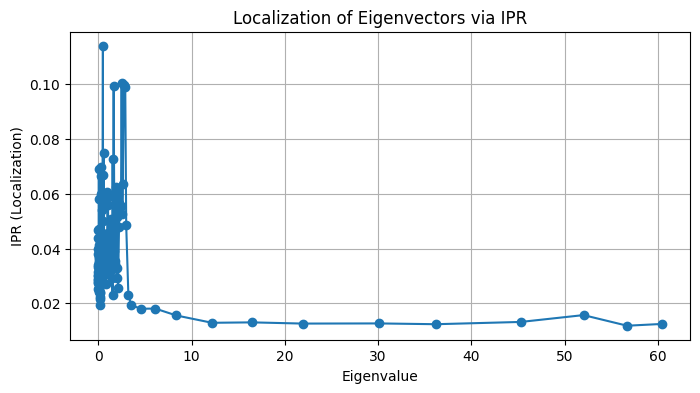

In [86]:
def compute_ipr(eigenvectors):
    """
    Compute Inverse Participation Ratio (IPR) for each eigenvector.
    Parameters:
        eigenvectors (np.ndarray): Matrix with eigenvectors as columns.
    Returns:
        list: IPR values.
    """
    ipr = []
    for v in eigenvectors.T:  # eigenvectors are columns
        norm_v = v / np.linalg.norm(v)
        ipr_val = np.sum(np.abs(norm_v)**4)
        ipr.append(ipr_val)
    return np.array(ipr)

# Example: Random symmetric matrix (can replace with your banded matrix)


# Eigen decomposition
eigvals, eigvecs = np.linalg.eigh(hermitian_matrix)

# Compute IPR
ipr_values = compute_ipr(eigvecs)

# Plot IPR
plt.figure(figsize=(8, 4))
plt.plot(eigvals, ipr_values, 'o-')
plt.xlabel('Eigenvalue')
plt.ylabel('IPR (Localization)')
plt.title('Localization of Eigenvectors via IPR')
plt.grid(True)
plt.show()

Now define the ansatz and vqc

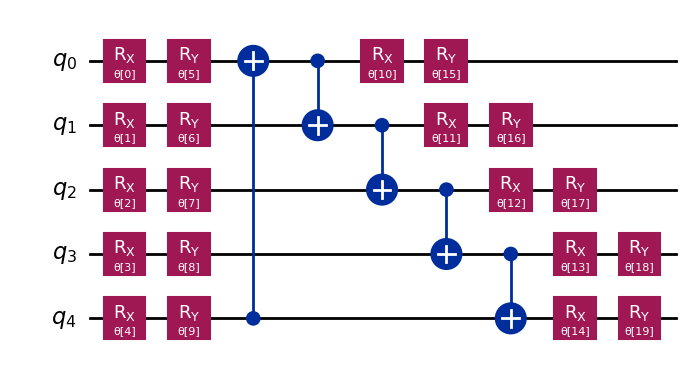

In [55]:
qc_ansatz_vqe=TwoLocal(qubits,rotation_blocks=["rx","ry"],entanglement="circular",entanglement_blocks="cx",reps=1)
qc_vqe=QuantumCircuit(qubits)
qc_vqe=qc_vqe.compose(qc_ansatz_vqe)
theta=np.random.rand(qc_ansatz_vqe.num_parameters)
qc_vqe.decompose().draw("mpl")

Now Estimator

In [56]:
estimator=StatevectorEstimator()
def obj_fun(params,qc_fun,ham,estimator_pri):
    job=estimator_pri.run([(qc_fun,ham,[params])]).result()[0]
    return job.data.evs
z=minimize(obj_fun,theta,args=(qc_vqe,Pauli,estimator),method="BFGS")

a=np.linalg.eig(hermitian_matrix)
print(f"All eigenvalues:{np.real(a[0])}")
print(f"Predicted VQE: {-z['fun']}")
print(f"True Value:{max(np.sort(np.real(a[0])))}")
#print(z)

All eigenvalues:[1.73763359e+00 1.83535845e+00 1.67979779e+00 1.51382126e+00
 1.24486774e+00 1.05470608e+00 8.61877251e-01 8.15431995e-01
 7.94513310e-01 7.47801712e-01 7.25591381e-01 5.91194545e-01
 6.40875118e-01 4.37214847e-01 4.01647238e-01 3.75850620e-01
 3.17108760e-01 2.52022610e-01 2.25462129e-01 2.32954477e-01
 1.73546058e-01 1.52100552e-01 1.48061839e-01 1.00654738e-01
 1.12121708e-01 5.36831545e-02 3.51450368e-02 9.74177258e-03
 1.91118173e-02 2.20076071e-03 2.99165276e-03 2.90610347e-04]
Predicted VQE: 1.7222926695592993
True Value:1.8353584521853172


Now execute multi vqc objective optimization

In [ ]:
def qc_ini(basis):
    for i,bit in enumerate(basis):
        if

basis=["1000"]